In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import os

In [38]:
def rotation_matrix_from_euler(roll_deg, pitch_deg, yaw_deg):
    # Convert degrees to radians
    roll = np.radians(roll_deg)
    pitch = np.radians(pitch_deg)
    yaw = np.radians(yaw_deg)
    
        # Rotation around X-axis (Roll)
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll),  np.cos(roll)]])
    
        # Rotation around Y-axis (Pitch)
    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])
    
        # Rotation around Z-axis (Yaw)
    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw),  np.cos(yaw), 0],
                    [0, 0, 1]])
    # Combined rotation: R = Rz * Ry * Rx
    R = R_z @ R_y @ R_x
    return R

def translation_matrix(x_shift, y_shift, z_shift):
    T = np.array([
        [1, 0, 0, x_shift],
        [0, 1, 0, y_shift],
        [0, 0, 1, z_shift],
        [0, 0, 0, 1]
        ])

In [35]:
class Camera:
    """
    Camera class for simulating each camera in a scanning setup.
    """
    def __init__(self, width, height, f, pixel_size):
        self.width = width              # width of the camera sensor in mm
        self.height = height            # height of the camera sensor in mm
        self.aspect = width/height
        self.pixel_size = pixel_size
        self.f = f                      # focal length of the camera lens
        self.K = np.array([[f, 0, width/2],
                           [0, f, height/2],
                           [0, 0, 1]])
        self.matrix = np.array([0,0,0])

    def capture(self, pose: list):
        """
        pose: [x_pos, y_pos, z_pos, roll_deg, pitch_deg, yaw_deg] 
        """
        # Extrinsic parameters (rotation and translation)     
        R = rotation_matrix_from_euler(pose[3], pose[4], pose[5])   # Identity rotation (camera aligned with world axes)
        t = np.array([pose[0], pose[1], pose[2]])  # Camera positioned 5 units away along the Z-axis
        
        # Combine extrinsics into 3x4 matrix
        Rt = np.hstack((R, t))
               
        # Projection matrix: P = K [R | t]
        P = self.K @ Rt
        
        # Project the point
        X_image = P @ X_world
        
        # Perspective division to get pixel coordinates
        x_pixel = X_image[0, 0] / X_image[2, 0]
        y_pixel = X_image[1, 0] / X_image[2, 0]
        
        print(f"Projected pixel coordinates: ({x_pixel:.2f}, {y_pixel:.2f})")
        return img

    def camera_pyramid(self):
        # this is the pyramid shape that is often used to represent a camera and its pose
        # recommend changing the z-distance to be focal lenght and the x,y to be sensor height and width
        pyramid = np.array([[self.coordinate[0], self.coordinate[1], self.coordinate[2]],
                            [self.coordinate[0]-4,self.coordinate[1]+3,self.coordinate[2] + 10],
                            [self.coordinate[0]+4,self.coordinate[1]+3,self.coordinate[2] + 10],
                            [self.coordinate[0]+4,self.coordinate[1]-3,self.coordinate[2] + 10],
                            [self.coordinate[0]-4,self.coordinate[1]-3,self.coordinate[2] + 10]])
        return pyramid
   



In [36]:
class Object:
    """
    Object class to define the object to be scanned. The object is positioned at the origin of the world coordinates
    thus the camera moves about the object. 
    """
    def __init__(self,filename: str):
        if not isinstance(filename, str):
            raise TypeError("The filename must be a string.")

        self.mesh = o3d.io.read_triangle_mesh(filename)

        # Check if the mesh is loaded correctly
        if not self.mesh.is_empty():
            print("STL file loaded successfully!")
        else:
            print("Failed to load STL file.")

        self.pcd = self.mesh.sample_points_uniformly(number_of_points=10000)  # Adjust the number of points as needed
        self.pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=30))


    def visualize(self):
        # Compute vertex normals for better visualization
        self.mesh.compute_vertex_normals()

        # Visualize the 3D mesh
        o3d.visualization.draw_geometries([self.mesh])

In [179]:
class Laser:
    """
    A laser illumination source that projects a grid of dots on the object. 

    pose: [x_pos, y_pos, z_pos, roll_deg, pitch_deg, yaw_deg] 
    """
    def __init__(self, pose: list, line: bool):
        self.pose = np.array(pose)

        if not line:
            self.type = "grid"
        else: 
            self.type = "line"

    def setup_grid(self, grid_size: int, dot_diameter: float, spacing: float):
        if not self.type == "grid":
            raise PermissionError("This method is only available for grid type lasers.")
        self.grid_size = np.array([grid_size,grid_size])
        self.dot_diameter = dot_diameter #mm
        """Creates a uniform grid of laser points."""
        #fig = plt.figure(figsize=(12, 12))
        #ax = fig.add_subplot(projection='3d')
        
        x = np.linspace(-grid_size, grid_size, spacing)
        y = np.linspace(-grid_size, grid_size, spacing)
        xv, yv = np.meshgrid(x, y)
        laser_origins = np.column_stack([xv.ravel(), yv.ravel(), np.zeros_like(xv.ravel())])
        #print(laser_origins.T[0])
        #ax.scatter(laser_origins.T[0], laser_origins.T[1], laser_origins.T[2])
        
        laser_origins = rotation_matrix_from_euler(self.pose[-3], self.pose[-2], self.pose[-1]) @ laser_origins[:].transpose()
        laser_origins = np.column_stack(laser_origins) + self.pose[:3]
        #print(laser_origins)
        #ax.scatter(laser_origins.T[0], laser_origins.T[1], laser_origins.T[2])
        ray_directions = np.tile([np.radians(self.pose[-3]), np.radians(self.pose[-2]),np.radians(self.pose[-1])], (laser_origins.shape[0], 1))

        #plt.show() 
        ray_tensor = o3d.core.Tensor(np.hstack([laser_origins, ray_directions]), dtype=o3d.core.Dtype.Float32)
        return laser_origins, ray_directions
    
    def setup_line(self, width: float):
        if not self.type == "line":
            raise PermissionError("This method is only available for line type lasers.")
        self.width = width

    def cast_rays(self, mesh, laser_origins, ray_directions):
        # Convert Open3D mesh to a ray-traceable structure
        scene = o3d.t.geometry.RaycastingScene()
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))
        
        # Convert laser origins and ray directions to tensor format
        ray_tensor = o3d.core.Tensor(np.hstack([laser_origins, ray_directions]), dtype=o3d.core.Dtype.Float32)
        
        # Perform ray tracing
        results = scene.cast_rays(ray_tensor)
        intersections = results["t_hit"].numpy()
        
        # Filter out invalid hits (Open3D returns inf if no hit)
        valid_mask = intersections != np.inf
        hit_points = laser_origins[valid_mask] + intersections[valid_mask, None] * ray_directions[valid_mask]
        
        # Convert to Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(hit_points)

        laser_grid = o3d.geometry.PointCloud()
        laser_grid.points = o3d.utility.Vector3dVector(laser_origins)
        create_direction_arrow = o3d.geometry.TriangleMesh.create_arrow()

        bbox = pcd.get_axis_aligned_bounding_box()
        print("Bounding Box:", bbox)
        
        # Visualize the hit points
        origin_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100)
        o3d.visualization.draw_geometries([mesh.paint_uniform_color([1, 0.706, 0]), pcd, laser_grid, origin_frame])

    def compute_laser_intensity(hit_points, normals, laser_dir=np.array([0, 0, -1]), I0=255):
        """Compute laser intensity based on surface normals."""
        cos_theta = np.einsum("ij,j->i", normals, -laser_dir)  # Efficient dot product
        intensity = np.clip(I0 * cos_theta, 0, 255)  # Ensure non-negative values
        return intensity
    







In [ ]:
def compute_reflection_intensity(hit_points, normals, laser_pos, camera_baseline=50, I0=255):
    """
    Compute laser reflection intensity based on Lambertian reflection,
    considering both laser and camera angles, where the cameras are
    offset from the laser but share the same viewing direction.
    
    Parameters:
    - hit_points: Nx3 array of laser intersection points
    - normals: Nx3 array of surface normals at hit points
    - laser_pos: 3D position of the laser
    - camera_baseline: Distance between the left and right cameras (centered around the laser)
    - I0: Initial laser intensity
    
    Returns:
    - intensities_left: Reflection intensity as seen by the left camera
    - intensities_right: Reflection intensity as seen by the right camera
    """
    intensities_left = []
    intensities_right = []

    # Compute left and right camera positions (translated along X)
    camera_left_pos = laser_pos + np.array([-camera_baseline / 2, 0, 0])
    camera_right_pos = laser_pos + np.array([camera_baseline / 2, 0, 0])

    for i, hit_point in enumerate(hit_points):
        normal = normals[i]

        # Compute laser direction (unit vector)
        laser_dir = (hit_point - laser_pos) / np.linalg.norm(hit_point - laser_pos)
        
        # Compute camera directions (left and right)
        camera_left_dir = (hit_point - camera_left_pos) / np.linalg.norm(hit_point - camera_left_pos)
        camera_right_dir = (hit_point - camera_right_pos) / np.linalg.norm(hit_point - camera_right_pos)

        # Compute angles (cosines) between normal and directions
        cos_theta_L = np.dot(normal, -laser_dir)  # Laser angle
        cos_theta_CL = np.dot(normal, -camera_left_dir)  # Left camera angle
        cos_theta_CR = np.dot(normal, -camera_right_dir)  # Right camera angle

        # Ensure non-negative values
        cos_theta_L = max(cos_theta_L, 0)
        cos_theta_CL = max(cos_theta_CL, 0)

        cos_theta_CR = max(cos_theta_CR, 0)

        # Compute intensity seen by each camera
        intensity_left = I0 * cos_theta_L * cos_theta_CL
        intensity_right = I0 * cos_theta_L * cos_theta_CR

        intensities_left.append(intensity_left)
        intensities_right.append(intensity_right)

    return np.array(intensities_left), np.array(intensities_right)

# Example Setup
laser_pos = np.array([0, 0, 100])  # Laser is above the object
camera_baseline = 50  # Cameras are 50mm apart, equally offset from the laser


In [193]:
grid = Laser([0,0,150,0,30,-90],False)
#grid.pose[-3:]
laser_origins, ray_directions = grid.setup_grid(10,1,10)
grid.cast_rays(duck.mesh, laser_origins, ray_directions)

# Get normals for hit points
#hit_normals = np.asarray(mesh.vertex_normals)[valid_mask]
        
# Compute intensity values
#intensities = compute_laser_intensity(hit_points, hit_normals)

Bounding Box: AxisAlignedBoundingBox: min: (-10, 30.1043, 26.36), max: (10, 48.483, 40.4524)


In [31]:
""" 
Setup code block
"""

# import object
duck_file = os.path.abspath("../../docs/Rubber_Duck.stl")
duck = Object(duck_file)

# create cameras
Lcam = Camera(2560,960, 2.43,12)
Rcam = Camera(2560,960, 2.43,12)



STL file loaded successfully!


In [9]:
"""
Scanning code block
"""


'\nScanning code block\n'

In [10]:
"""
Image Processing code block
"""

'\nImage Processing code block\n'

In [11]:
"""
Model Creation code block
"""

'\nModel Creation code block\n'

In [19]:
duck.visualize()


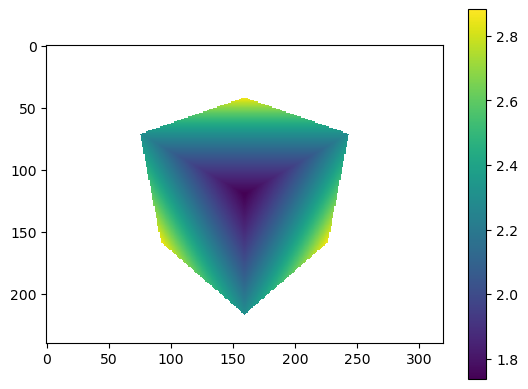

In [25]:
cube = o3d.t.geometry.TriangleMesh.from_legacy(
                                    o3d.geometry.TriangleMesh.create_box())

# Create scene and add the cube mesh
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(cube)

# Rays are 6D vectors with origin and ray direction.
# Here we use a helper function to create rays for a pinhole camera.
rays = scene.create_rays_pinhole(fov_deg=60,
                                 center=[0.5,0.5,0.5],
                                 eye=[-1,-1,-1],
                                 up=[0,0,1],
                                 width_px=320,
                                 height_px=240)

# Compute the ray intersections.
ans = scene.cast_rays(rays)

# Visualize the hit distance (depth)
plt.imshow(ans['t_hit'].numpy())
plt.colorbar()

In [33]:
# Create scene and add the monkey model.
#scene = o3d.t.geometry.RaycastingScene()
#d = o3d.data.MonkeyModel()
#mesh = o3d.t.io.read_triangle_mesh(d.path)
mesh = duck.mesh
mesh_id = scene.add_triangles(mesh)

# Create a grid of rays covering the bounding box
bb_min = mesh.vertex['positions'].min(dim=0).numpy()
bb_max = mesh.vertex['positions'].max(dim=0).numpy()
x,y = np.linspace(bb_min, bb_max, num=10)[:,:2].T
xv, yv = np.meshgrid(x,y)
orig = np.stack([xv, yv, np.full_like(xv, bb_min[2]-1)], axis=-1).reshape(-1,3)
dest = orig + np.full(orig.shape, (0,0,2+bb_max[2]-bb_min[2]),dtype=np.float32)
rays = np.concatenate([orig, dest-orig], axis=-1).astype(np.float32)

# Compute the ray intersections.
lx = scene.list_intersections(rays)
lx = {k:v.numpy() for k,v in lx.items()}

# Calculate intersection coordinates using the primitive uvs and the mesh
v = mesh.vertex['positions'].numpy()
t = mesh.triangle['indices'].numpy()
tidx = lx['primitive_ids']
uv = lx['primitive_uvs']
w = 1 - np.sum(uv, axis=1)
c = \
v[t[tidx, 1].flatten(), :] * uv[:, 0][:, None] + \
v[t[tidx, 2].flatten(), :] * uv[:, 1][:, None] + \
v[t[tidx, 0].flatten(), :] * w[:, None]

# Calculate intersection coordinates using ray_ids
c = rays[lx['ray_ids']][:,:3] + rays[lx['ray_ids']][:,3:]*lx['t_hit'][...,None]

# Visualize the rays and intersections.
lines = o3d.t.geometry.LineSet()
lines.point.positions = np.hstack([orig,dest]).reshape(-1,3)
lines.line.indices = np.arange(lines.point.positions.shape[0]).reshape(-1,2)
lines.line.colors = np.full((lines.line.indices.shape[0],3), (1,0,0))
x = o3d.t.geometry.PointCloud(positions=c)
o3d.visualization.draw([mesh, lines, x], point_size=8)

TypeError: add_triangles(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.t.geometry.RaycastingScene, vertex_positions: open3d.cpu.pybind.core.Tensor, triangle_indices: open3d.cpu.pybind.core.Tensor) -> int
    2. (self: open3d.cpu.pybind.t.geometry.RaycastingScene, mesh: open3d.cpu.pybind.t.geometry.TriangleMesh) -> int

Invoked with: <open3d.cpu.pybind.t.geometry.RaycastingScene object at 0x0000011C5C540FB0>, TriangleMesh with 5482 points and 10960 triangles.

In [132]:
duck